In [1]:
## installing required modules
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.9 MB/s eta 0:00:00


In [2]:

## importing required modules

import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_addons as tfa
import tensorflow_datasets as tfds

tfds.disable_progress_bar()
autotune = tf.data.AUTOTUNE


In [3]:
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
## changing current directory to a HW6 folder in drive 

root_dir = "/content/drive/MyDrive/Deep Learning Google Colab/HW6/"
os.chdir(root_dir)

Loading dataset

In [5]:
# Loading apple2orange dataset from tensorflow-datasets

dataset, _ = tfds.load('cycle_gan/apple2orange', with_info=True, as_supervised=True)
train_apples, train_oranges = dataset["trainA"], dataset["trainB"]
test_apples, test_oranges = dataset["testA"], dataset["testB"]

Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/apple2orange/2.0.0. Subsequent calls will reuse this data.


In [6]:

# standard image size.
orig_img_size = (286, 286)

# Size of the random crops to be used during training.
input_img_size = (256, 256, 3)

# Weights initializer for the layers.
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

# Gamma initializer for instance normalization.
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

buffer_size = 256
batch_size = 1

In [7]:
## defining functions for image processing

def normalize_img(img):
    img = tf.cast(img, dtype=tf.float32)
    # Map values in the range [-1, 1]
    return (img / 127.5) - 1.0


def preprocess_train_image(img, label):
    # Random flip
    img = tf.image.random_flip_left_right(img)
    # Resize to the original size first
    img = tf.image.resize(img, [*orig_img_size])
    # Random crop to 256X256
    img = tf.image.random_crop(img, size=[*input_img_size])
    # Normalize the pixel values in the range [-1, 1]
    img = normalize_img(img)
    return img


def preprocess_test_image(img, label):
    # Only resizing and normalization for the test images.
    img = tf.image.resize(img, [input_img_size[0], input_img_size[1]])
    img = normalize_img(img)
    return img


Creating training and testing batches 

In [8]:
# Apply the preprocessing operations to the training data

train_apples = (
    train_apples.map(preprocess_train_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)

train_oranges = (
    train_oranges.map(preprocess_train_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)

In [9]:
# Apply the preprocessing operations to the test data

test_apples = (
    test_apples.map(preprocess_test_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)

test_oranges = (
    test_oranges.map(preprocess_test_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)


Visualizing the data

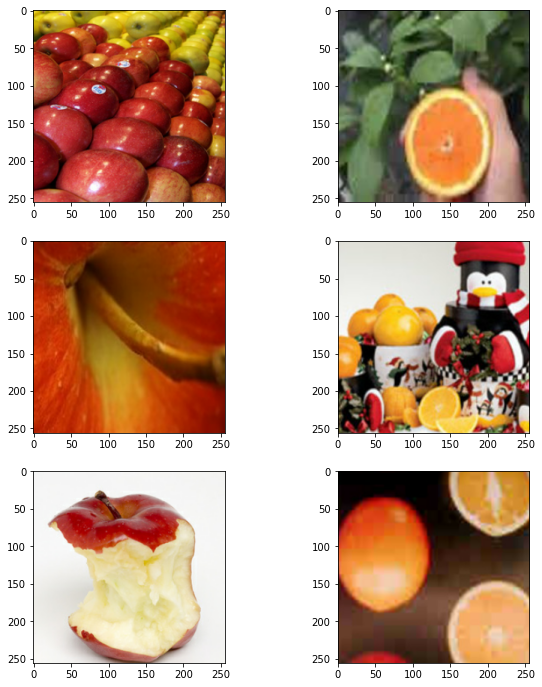

In [10]:
_, ax = plt.subplots(3, 2, figsize=(10, 12))
for i, samples in enumerate(zip(train_apples.take(3), train_oranges.take(3))):
    apple = (((samples[0][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
    orange = (((samples[1][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
    ax[i, 0].imshow(apple)
    ax[i, 1].imshow(orange)
plt.show()


#**Cycle GAN**

Functions for building generator and discriminator

In [11]:
class ReflectionPadding2D(layers.Layer):
    """Implements Reflection Padding as a layer.

    Args:
        padding(tuple): Amount of padding for the
        spatial dimensions.

    Returns:
        A padded tensor with the same type as the input tensor.
    """

    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return tf.pad(input_tensor, padding_tensor, mode="REFLECT")


In [12]:
def residual_block(
    x,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="valid",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    dim = x.shape[-1]
    input_tensor = x

    x = ReflectionPadding2D()(input_tensor)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = activation(x)

    x = ReflectionPadding2D()(x)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.add([input_tensor, x])
    return x

In [13]:
def downsample(
    x,
    filters,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2D(
        filters,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x


In [14]:
def upsample(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    kernel_initializer=kernel_init,
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2DTranspose(
        filters,
        kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x

## Generator

The generator consists of a convolution block on each end and in between are 2 downsampling blocks, 9 residual blocks and 2 upsampling blocks. 




In [15]:
def get_resnet_generator(
    filters=64,
    num_downsampling_blocks=2,
    num_residual_blocks=9,
    num_upsample_blocks=2,
    gamma_initializer=gamma_init,
    name=None,
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = ReflectionPadding2D(padding=(3, 3))(img_input)                                      ## calling the Refelction padding class defined above
    x = layers.Conv2D(filters, (7, 7), kernel_initializer=kernel_init, use_bias=False)(
        x
    )
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.Activation("relu")(x)

    # Downsampling
    for _ in range(num_downsampling_blocks):
        filters *= 2
        x = downsample(x, filters=filters, activation=layers.Activation("relu"))    ## calling the downsample function defined above

    # Residual blocks
    for _ in range(num_residual_blocks):
        x = residual_block(x, activation=layers.Activation("relu"))                 ## calling the residual_block function defined above

    # Upsampling
    for _ in range(num_upsample_blocks):
        filters //= 2
        x = upsample(x, filters, activation=layers.Activation("relu"))             ## calling the upsample function defined above

    # Final block
    x = ReflectionPadding2D(padding=(3, 3))(x)
    x = layers.Conv2D(3, (7, 7), padding="valid")(x)
    x = layers.Activation("tanh")(x)

    model = keras.models.Model(img_input, x, name=name)
    return model

## Discriminator

The generator consists 4 convolutions blocks


In [16]:
def get_discriminator(
    filters=64, kernel_initializer=kernel_init, num_downsampling=3, name=None
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = layers.Conv2D(
        filters,
        (4, 4),
        strides=(2, 2),
        padding="same",
        kernel_initializer=kernel_initializer,
    )(img_input)
    x = layers.LeakyReLU(0.2)(x)

    num_filters = filters
    for num_downsample_block in range(3):
        num_filters *= 2
        if num_downsample_block < 2:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(2, 2),
            )
        else:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(1, 1),
            )

    x = layers.Conv2D(
        1, (4, 4), strides=(1, 1), padding="same", kernel_initializer=kernel_initializer
    )(x)

    model = keras.models.Model(inputs=img_input, outputs=x, name=name)
    return model

In [17]:
### variables for generators and discrimintors

# generators
gen_G = get_resnet_generator(name="generator_G")
gen_F = get_resnet_generator(name="generator_F")

#  discriminators
disc_X = get_discriminator(name="discriminator_X")
disc_Y = get_discriminator(name="discriminator_Y")

/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


## Building Cycle GAN

In [18]:
class CycleGan(keras.Model):
    def __init__(
        self,
        generator_G,
        generator_F,
        discriminator_X,
        discriminator_Y,
        lambda_cycle=10.0,
        lambda_identity=0.5,
    ):
        super(CycleGan, self).__init__()
        self.gen_G = generator_G
        self.gen_F = generator_F
        self.disc_X = discriminator_X
        self.disc_Y = discriminator_Y
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity

    def call(self, inputs):
        return (
            self.disc_X(inputs),
            self.disc_Y(inputs),
            self.gen_G(inputs),
            self.gen_F(inputs),
        )

    def compile(
        self,
        gen_G_optimizer,
        gen_F_optimizer,
        disc_X_optimizer,
        disc_Y_optimizer,
        gen_loss_fn,
        disc_loss_fn,
    ):
        super(CycleGan, self).compile()
        self.gen_G_optimizer = gen_G_optimizer
        self.gen_F_optimizer = gen_F_optimizer
        self.disc_X_optimizer = disc_X_optimizer
        self.disc_Y_optimizer = disc_Y_optimizer
        self.generator_loss_fn = gen_loss_fn
        self.discriminator_loss_fn = disc_loss_fn
        self.cycle_loss_fn = keras.losses.MeanAbsoluteError()
        self.identity_loss_fn = keras.losses.MeanAbsoluteError()

    def train_step(self, batch_data):
        # x is Apple and y is Orange
        real_x, real_y = batch_data

        # For CycleGAN, we need to calculate different
        # kinds of losses for the generators and discriminators.
        # We will perform the following steps here:
        #
        # 1. Pass real images through the generators and get the generated images
        # 2. Pass the generated images back to the generators to check if we
        #    we can predict the original image from the generated image.
        # 3. Do an identity mapping of the real images using the generators.
        # 4. Pass the generated images in 1) to the corresponding discriminators.
        # 5. Calculate the generators total loss (adverserial + cycle + identity)
        # 6. Calculate the discriminators loss
        # 7. Update the weights of the generators
        # 8. Update the weights of the discriminators
        # 9. Return the losses in a dictionary

        with tf.GradientTape(persistent=True) as tape:
            # Apple to fake Orange
            fake_y = self.gen_G(real_x, training=True)
            # Orange to fake Apple -> y2x
            fake_x = self.gen_F(real_y, training=True)

            # Cycle (Apple to fake Orange to fake Apple): x -> y -> x
            cycled_x = self.gen_F(fake_y, training=True)
            # Cycle (Orange to fake Apple to fake Orange) y -> x -> y
            cycled_y = self.gen_G(fake_x, training=True)

            # Identity mapping
            same_x = self.gen_F(real_x, training=True)
            same_y = self.gen_G(real_y, training=True)

            # Discriminator output
            disc_real_x = self.disc_X(real_x, training=True)
            disc_fake_x = self.disc_X(fake_x, training=True)

            disc_real_y = self.disc_Y(real_y, training=True)
            disc_fake_y = self.disc_Y(fake_y, training=True)

            # Generator adverserial loss
            gen_G_loss = self.generator_loss_fn(disc_fake_y)
            gen_F_loss = self.generator_loss_fn(disc_fake_x)

            # Generator cycle loss
            cycle_loss_G = self.cycle_loss_fn(real_y, cycled_y) * self.lambda_cycle
            cycle_loss_F = self.cycle_loss_fn(real_x, cycled_x) * self.lambda_cycle

            # Generator identity loss
            id_loss_G = (
                self.identity_loss_fn(real_y, same_y)
                * self.lambda_cycle
                * self.lambda_identity
            )
            id_loss_F = (
                self.identity_loss_fn(real_x, same_x)
                * self.lambda_cycle
                * self.lambda_identity
            )

            # Total generator loss
            total_loss_G = gen_G_loss + cycle_loss_G + id_loss_G
            total_loss_F = gen_F_loss + cycle_loss_F + id_loss_F

            # Discriminator loss
            disc_X_loss = self.discriminator_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = self.discriminator_loss_fn(disc_real_y, disc_fake_y)

        # Get the gradients for the generators
        grads_G = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
        grads_F = tape.gradient(total_loss_F, self.gen_F.trainable_variables)

        # Get the gradients for the discriminators
        disc_X_grads = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
        disc_Y_grads = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

        # Update the weights of the generators
        self.gen_G_optimizer.apply_gradients(
            zip(grads_G, self.gen_G.trainable_variables)
        )
        self.gen_F_optimizer.apply_gradients(
            zip(grads_F, self.gen_F.trainable_variables)
        )

        # Update the weights of the discriminators
        self.disc_X_optimizer.apply_gradients(
            zip(disc_X_grads, self.disc_X.trainable_variables)
        )
        self.disc_Y_optimizer.apply_gradients(
            zip(disc_Y_grads, self.disc_Y.trainable_variables)
        )

        return {
            "G_loss": total_loss_G,
            "F_loss": total_loss_F,
            "D_X_loss": disc_X_loss,
            "D_Y_loss": disc_Y_loss,
        }


Creating a Callback to save generated images 

In [19]:
class GANMonitor(keras.callbacks.Callback):
    """A callback to generate and save images after each epoch"""

    def __init__(self, num_img=2):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        _, ax = plt.subplots(2, 2, figsize=(12, 12))
        for i, img in enumerate(test_apples.take(self.num_img)):
            prediction = self.model.gen_G(img)[0].numpy()
            prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
            img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

            ax[i, 0].imshow(img)
            ax[i, 1].imshow(prediction)
            ax[i, 0].set_title("Input image")
            ax[i, 1].set_title("Translated image")
            ax[i, 0].axis("off")
            ax[i, 1].axis("off")

            prediction = keras.preprocessing.image.array_to_img(prediction)
            prediction.save(
                "generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch + 1)
            )
        plt.show()
        plt.close()

## Training the end to end model

In [20]:
## creating directory for saving weights

folder_path ='./model_checkpoints/'

if os.path.exists(folder_path) == True:
    None
else:
    os.makedirs(folder_path)

In [21]:
# Loss function for evaluating adversarial loss
adv_loss_fn = keras.losses.MeanSquaredError()

# Define the loss function for the generators
def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
    return fake_loss


# Define the loss function for the discriminators
def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5

In [32]:
# Create cycle gan model
cycle_gan_model = CycleGan(
    generator_G=gen_G, generator_F=gen_F, discriminator_X=disc_X, discriminator_Y=disc_Y
)

# Compile the model
cycle_gan_model.compile(
    gen_G_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_F_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_X_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_Y_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn,
)

In [22]:
# Callbacks
plotter = GANMonitor()
checkpoint_filepath = "./model_checkpoints/cyclegan_checkpoints_{epoch:03d}.hdf5"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_freq = 'epoch'
)

Epoch 1/3
995/995 [==============================] - ETA: 0s - G_loss: 3.0130 - F_loss: 2.9054 - D_X_loss: 0.2213 - D_Y_loss: 0.1995

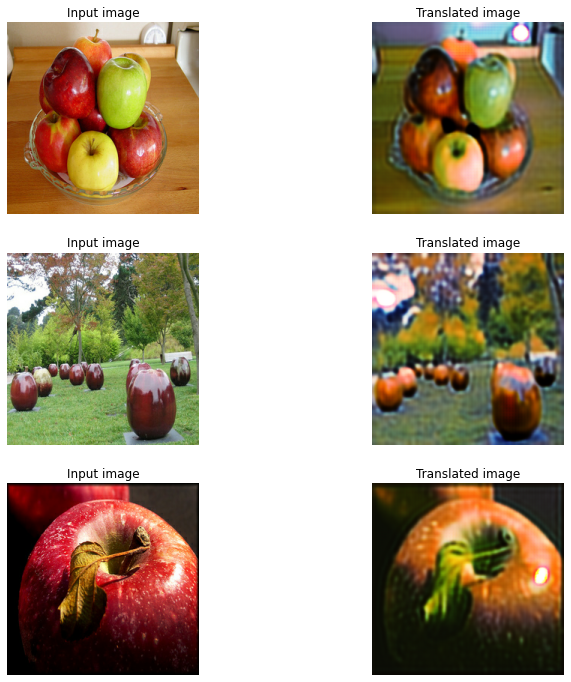

995/995 [==============================] - 611s 614ms/step - G_loss: 3.0131 - F_loss: 2.9053 - D_X_loss: 0.2212 - D_Y_loss: 0.1995
Epoch 2/3
995/995 [==============================] - ETA: 0s - G_loss: 2.9717 - F_loss: 2.8260 - D_X_loss: 0.2230 - D_Y_loss: 0.2039

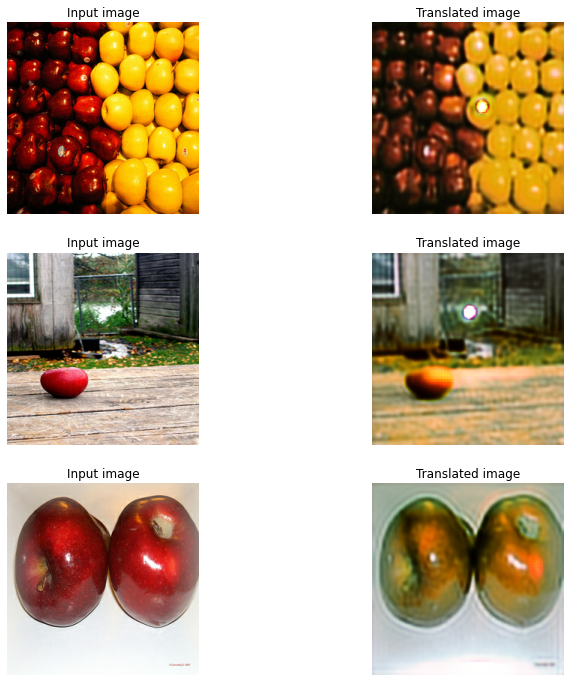

995/995 [==============================] - 612s 615ms/step - G_loss: 2.9722 - F_loss: 2.8273 - D_X_loss: 0.2230 - D_Y_loss: 0.2039
Epoch 3/3
995/995 [==============================] - ETA: 0s - G_loss: 2.9301 - F_loss: 2.7374 - D_X_loss: 0.2214 - D_Y_loss: 0.1982

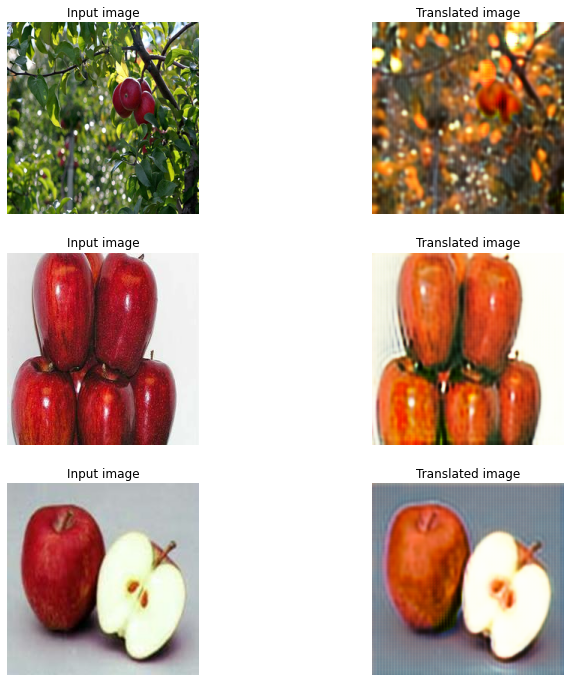

995/995 [==============================] - 612s 615ms/step - G_loss: 2.9339 - F_loss: 2.7374 - D_X_loss: 0.2215 - D_Y_loss: 0.1981


In [44]:
# Here we will train the model for just one epoch as each epoch takes around
# 7 minutes on a single P100 backed machine.

cycle_gan_model.fit(
    tf.data.Dataset.zip((train_apples, train_oranges)),
    epochs=3,
    callbacks=[plotter, model_checkpoint_callback]
)

Retraining Cycle GAN for few more epochs 

In [38]:
cycle_gan_model2 = CycleGan(
    generator_G=gen_G, generator_F=gen_F, discriminator_X=disc_X, discriminator_Y=disc_Y
)

cycle_gan_model2.build(input_shape=(None,input_img_size[0],input_img_size[1],input_img_size[2]))

# Compile the model
cycle_gan_model2.compile(
    gen_G_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_F_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_X_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_Y_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn,
)

In [41]:
# Load the checkpoints
weight_file = "./model_checkpoints/cyclegan_checkpoints_003.hdf5"
cycle_gan_model2.load_weights(weight_file)
print("Weights loaded successfully")

Weights loaded successfully


Epoch 4/10
995/995 [==============================] - ETA: 0s - G_loss: 2.8785 - F_loss: 2.6934 - D_X_loss: 0.2215 - D_Y_loss: 0.2005

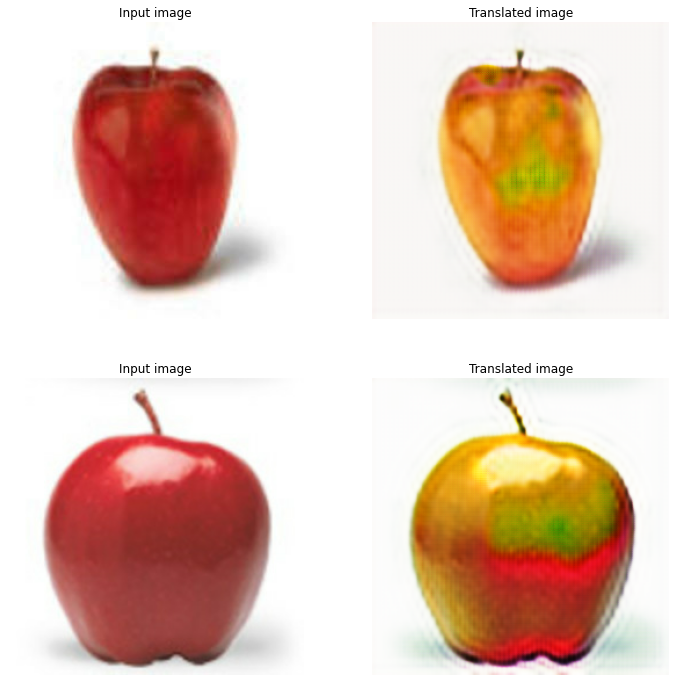

995/995 [==============================] - 767s 631ms/step - G_loss: 2.8778 - F_loss: 2.6925 - D_X_loss: 0.2216 - D_Y_loss: 0.2005
Epoch 5/10
995/995 [==============================] - ETA: 0s - G_loss: 2.7868 - F_loss: 2.6223 - D_X_loss: 0.2194 - D_Y_loss: 0.2077

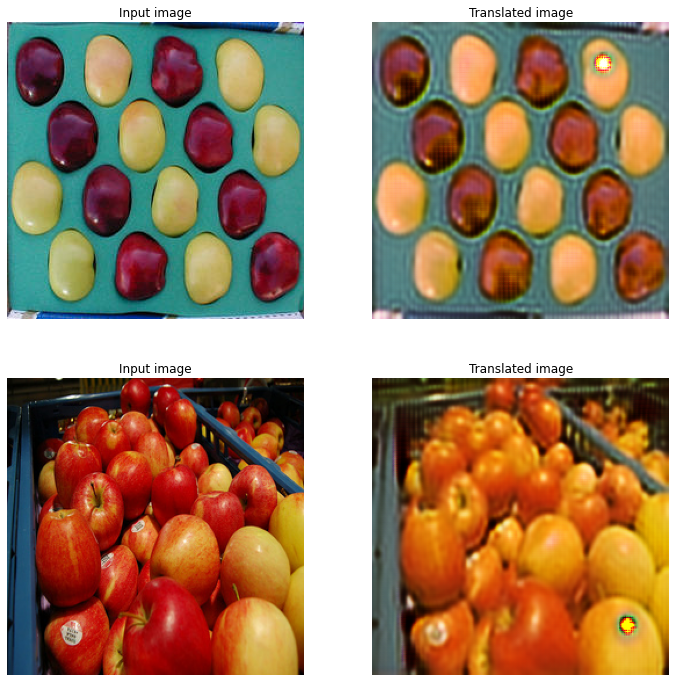

995/995 [==============================] - 647s 650ms/step - G_loss: 2.7858 - F_loss: 2.6216 - D_X_loss: 0.2195 - D_Y_loss: 0.2077
Epoch 6/10
995/995 [==============================] - ETA: 0s - G_loss: 2.7397 - F_loss: 2.5605 - D_X_loss: 0.2175 - D_Y_loss: 0.2109

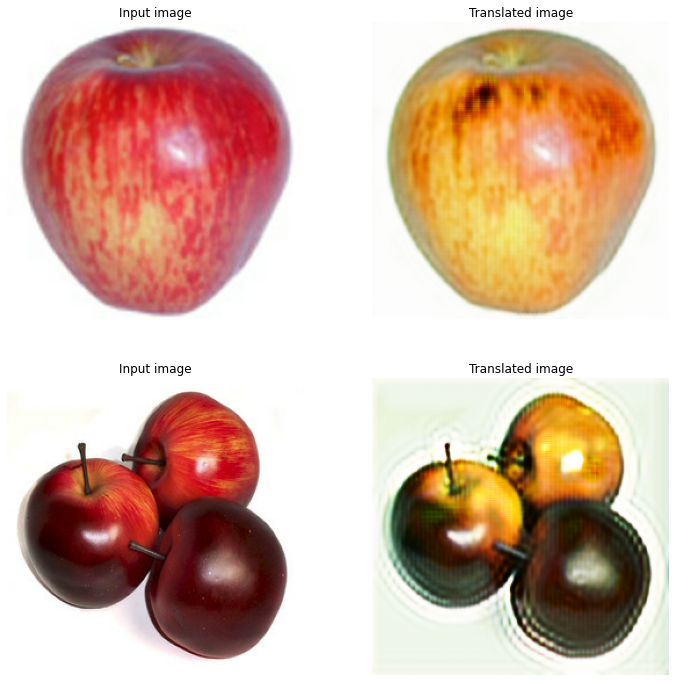

995/995 [==============================] - 632s 636ms/step - G_loss: 2.7390 - F_loss: 2.5597 - D_X_loss: 0.2175 - D_Y_loss: 0.2111
Epoch 7/10
995/995 [==============================] - ETA: 0s - G_loss: 2.6544 - F_loss: 2.5483 - D_X_loss: 0.2151 - D_Y_loss: 0.2114

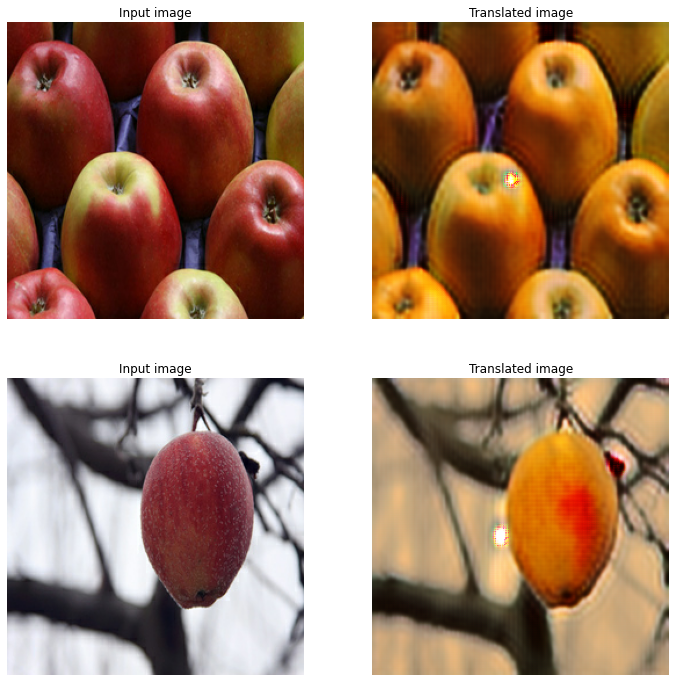

995/995 [==============================] - 630s 633ms/step - G_loss: 2.6548 - F_loss: 2.5474 - D_X_loss: 0.2150 - D_Y_loss: 0.2113
Epoch 8/10
995/995 [==============================] - ETA: 0s - G_loss: 2.6610 - F_loss: 2.5109 - D_X_loss: 0.2171 - D_Y_loss: 0.2055

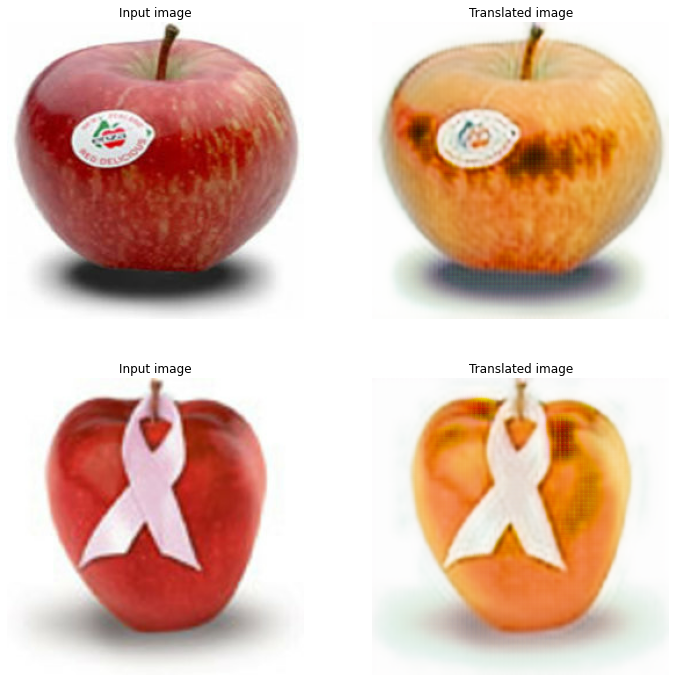

995/995 [==============================] - 628s 631ms/step - G_loss: 2.6609 - F_loss: 2.5109 - D_X_loss: 0.2171 - D_Y_loss: 0.2055
Epoch 9/10
830/995 [========================>.....] - ETA: 1:43 - G_loss: 2.5995 - F_loss: 2.4541 - D_X_loss: 0.2214 - D_Y_loss: 0.2024

In [ ]:
cycle_gan_model2.fit(
    tf.data.Dataset.zip((train_apples, train_oranges)),
    epochs=10,
    callbacks=[plotter, model_checkpoint_callback],
    initial_epoch=3
)

In [ ]:
### The runtime disconnected hence its at half of 9th Epoch, using 8th Epoch weights for predictions

## Testing model performance

In [23]:
## initialising a new model variable for prediction 

cycle_gan_model3 = CycleGan(
    generator_G=gen_G, generator_F=gen_F, discriminator_X=disc_X, discriminator_Y=disc_Y
)

cycle_gan_model3.build(input_shape=(None,input_img_size[0],input_img_size[1],input_img_size[2]))

# Compile the model
cycle_gan_model3.compile(
    gen_G_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_F_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_X_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_Y_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn,
)

In [24]:
# Load the weights for prediction
weight_file = "./model_checkpoints/cyclegan_checkpoints_008.hdf5"
cycle_gan_model3.load_weights(weight_file)
print("Weights loaded successfully")

Weights loaded successfully


Apples to Oranges - Test

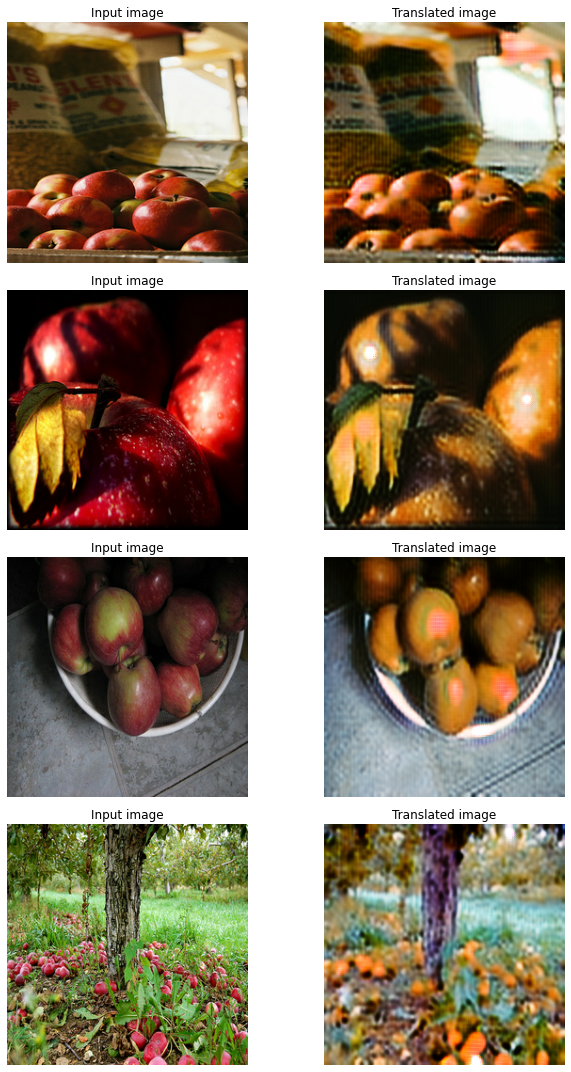

In [27]:
_, ax = plt.subplots(4, 2, figsize=(10, 15))
for i, img in enumerate(test_apples.take(4)):
    prediction = cycle_gan_model3.gen_G(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input image")
    ax[i, 0].set_title("Input image")
    ax[i, 1].set_title("Translated image")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")

    prediction = keras.preprocessing.image.array_to_img(prediction)
    prediction.save("predicted_img_apl2orng_{i}.png".format(i=i))
plt.tight_layout()
plt.show()

Oranges to Apple - Test

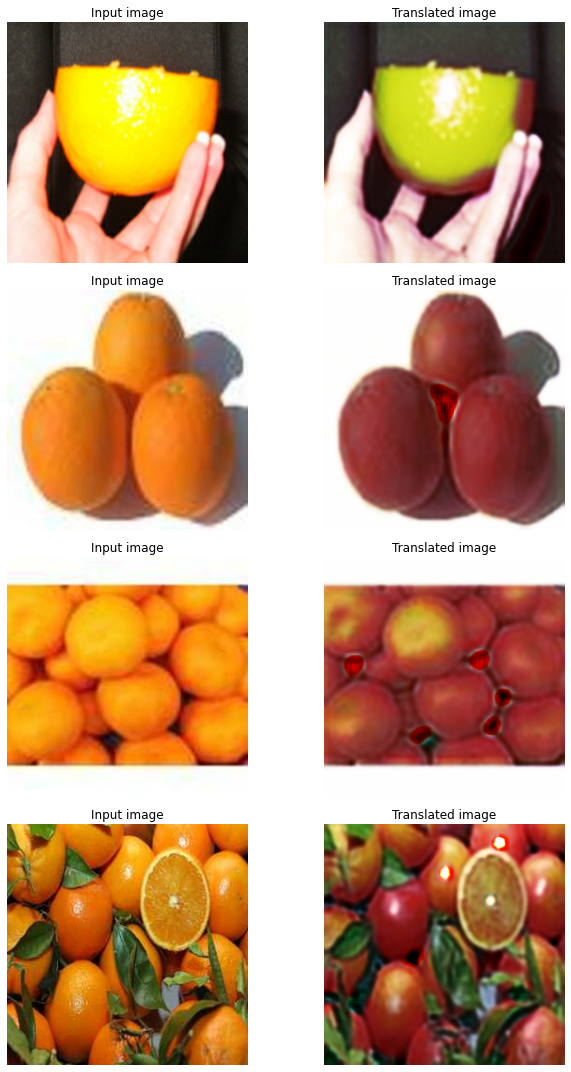

In [35]:
## oranges to apples - test

_, ax = plt.subplots(4, 2, figsize=(10, 15))
for i, img in enumerate(test_oranges.take(4)):
    prediction = cycle_gan_model3.gen_F(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input image")
    ax[i, 1].set_title("Translated image")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")

    prediction = keras.preprocessing.image.array_to_img(prediction)
    prediction.save("predicted_img_orng2apl_{i}.png".format(i=i))
plt.tight_layout()
plt.show()

## Applying CycleGAN to favourite picture

In [36]:
import cv2

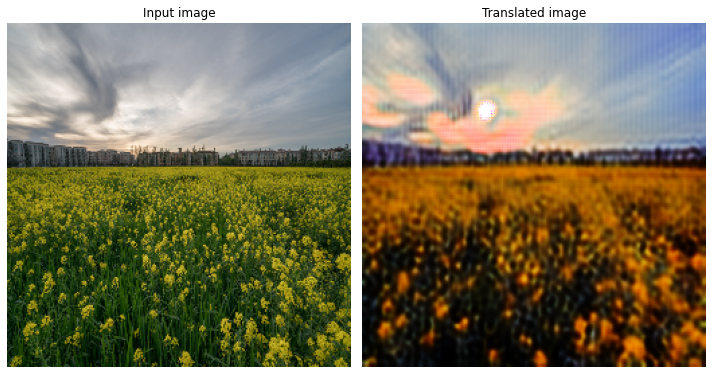

In [50]:
_, ax = plt.subplots(1, 2, figsize=(10, 6))

img = cv2.imread('PXL_20220705_022504865.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = tf.image.resize(img, [input_img_size[0], input_img_size[1]])
img = normalize_img(img)
img = np.expand_dims(img, axis=0)

prediction = cycle_gan_model3.gen_G(img, training=False)[0].numpy()
prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
img = (img[0] * 127.5 + 127.5).astype(np.uint8)

ax[0].imshow(img)
ax[1].imshow(prediction)
ax[0].set_title("Input image")
ax[1].set_title("Translated image")
ax[0].axis("off")
ax[1].axis("off")

prediction = keras.preprocessing.image.array_to_img(prediction)
prediction.save("predicted_favimg_genG.png".format(i=i))

plt.tight_layout()
plt.show()

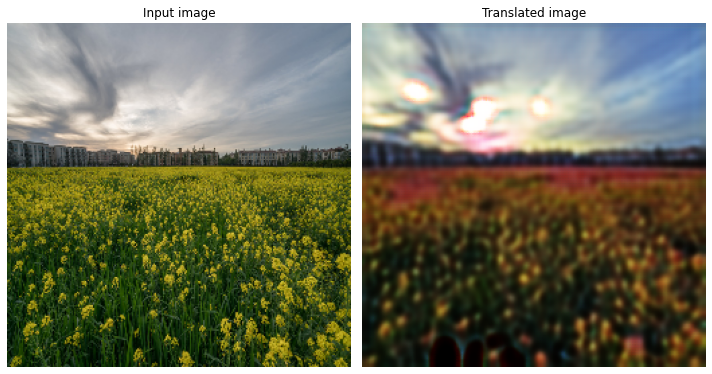

In [52]:
_, ax = plt.subplots(1, 2, figsize=(10, 6))

img = cv2.imread('PXL_20220705_022504865.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = tf.image.resize(img, [input_img_size[0], input_img_size[1]])
img = normalize_img(img)
img = np.expand_dims(img, axis=0)

prediction = cycle_gan_model3.gen_F(img, training=False)[0].numpy()
prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
img = (img[0] * 127.5 + 127.5).astype(np.uint8)

ax[0].imshow(img)
ax[1].imshow(prediction)
ax[0].set_title("Input image")
ax[1].set_title("Translated image")
ax[0].axis("off")
ax[1].axis("off")

prediction = keras.preprocessing.image.array_to_img(prediction)
prediction.save("predicted_favimg_genF.png".format(i=i))

plt.tight_layout()
plt.show()

Tested CycleGAN, both Generators, on own image. The gen_G generator (apples to oranges) converted the yellow flowers to orange flowers. 
Similarly, gen_F generator (oranges to apple) converted most yellow flowers to red. 
The generators are mildly trained, but more epochs will produce a better image with more clarity. 